In [84]:
# Import required libraries 

import numpy as np
import random
import copy
from numba import jit
import time
import cProfile

In [85]:
class World:
    """
    The World class encapsulates information about the computational domain.
    
    Attributes
    ----------
    <to be written later>
    ----------
    
    """
    
    def __init__(self, ni, nj, nk):
        """
        Initializes the World object with the grid parameters
        ni, nj, nk

        Parameters
        ----------
        ni : int
            number of grid points along x coordinate
        nj : int
            number of grid points along y coordinate
        nk : int
            number of grid points along z coordinate
        ----------
        
        """
        
        self.ni = ni # number of grid points along x coordinate
        self.nj = nj # number of grid points along y coordinate
        self.nk = nk # number of grid points along z coordinate
        
        self.nn = np.zeros(3) # number of grid points along x,y,z coordinates
        
        self.nn[0] = self.ni # number of grid points along x coordinate
        self.nn[1] = self.nj # number of grid points along y coordinate
        self.nn[2] = self.nk # number of grid points along z coordinate
        
        self.x0 = np.zeros(3) # mesh origin vector
        self.dh = np.zeros(3) # mesh spacing vector
        self.xm = np.zeros(3) # mesh max bound vector
        self.xc = np.zeros(3) # mesh centroid
        
        self.EPS_0 = 8.85418782e-12    # epsilon_0
        self.QE    = 1.602176565e-19;  # proton charge
        self.AMU   = 1.660538921e-27   # amu
        self.ME    = 9.10938215e-31;   # mass of electron    
        self.K     = 1.380648e-23;     # Boltzmann's const.
        self.EvToK = self.QE/self.K;   # 1 eV = q/k
        
        self.phi        = np.zeros((self.ni, self.nj, self.nk)) # potential phi
        self.object_id  = np.zeros((self.ni, self.nj, self.nk)) # grid point classifier
        self.phi_new    = np.zeros((self.ni, self.nj, self.nk)) # array for phi_new
        self.R          = np.zeros((self.ni, self.nj, self.nk)) # residual R
        self.R1         = np.zeros((self.ni, self.nj, self.nk)) # residual R
        self.rho        = np.zeros((self.ni, self.nj, self.nk)) # rho
        self.node_vol   = np.zeros((self.ni, self.nj, self.nk)) # node volume
        self.ef         = np.zeros((self.ni, self.nj, self.nk, 3)) # electric field
    
    def setTime(self, dt, num_ts):
        """
        Set simulation timestep and total number of timesteps.
        
        Parameters
        ----------
        dt : float
            simulation timestep
        num_ts : int
            total number of timesteps
        ----------
        
        """
        self.dt     = dt     # timestep
        self.num_ts = num_ts # total number of timesteps
        
    def setExtents(self, x1, y1, z1, x2, y2, z2):
        
        """
        Set mesh extents and compute grid spacing.

        Parameters
        ----------
        x1 : float
            x-coordinate of world origin
        y1 : float
            y-coordinate of world origin
        z1 : float
            z-coordinate of world origin
        x2 : float
            x-coordinate of world max bound
        y2 : float
            y-coordinate of world max bound
        z2 : float
            z-coordinate of world max bound
        ----------
        
        """
        
        self.x0[0] = x1 # x-coordinate of world origin
        self.x0[1] = y1 # y-coordinate of world origin
        self.x0[2] = z1 # z-coordinate of world origin
        
        self.xm[0] = x2 #x-coordinate of world max bound
        self.xm[1] = y2 #y-coordinate of world max bound
        self.xm[2] = z2 #z-coordinate of world max bound 
        
        # Compute mesh spacing dh, and mesh centroid
        for i in range(3):
            self.dh[i] = (self.xm[i] - self.x0[i]) / (self.nn[i] - 1)
            self.xc[i] = 0.5*(self.x0[i] + self.xm[i]) 
        
        # Compute node volumes
        self.computeNodeVolumes()
        
    def addSphere(self, sphere_x0, sphere_radius, sphere_phi):
        """
        Add sphere to grid using sugarcube technique.

        Parameters
        ----------
        sphere_x0 : numpy.ndarray
            position vector of sphere origin (xs0, ys0, zs0)
        sphere_radius : float
            sphere radius
        sphere_phi : float
            sphere potential
        ----------
        
        """
        
        self.sphere_x0     = sphere_x0        # sphere origin
        self.sphere_radius = sphere_radius    # sphere radius
        self.sphere_radius2= sphere_radius**2 # sphere radius^2
        self.sphere_phi    = sphere_phi       # sphere potential

        # loop over all i, j, k

        for i in np.arange(0, self.ni):
            for j in np.arange(0, self.nj):
                for k in np.arange(0, self.nk):

                    # check if pos(i,j,k) lies inside sphere
                    x = self.pos(np.array([i,j,k]))

                    if self.inSphere(x):
                        # if inside, set object_id[i,j,k] = 1,
                        # if inside, set phi[i,j,k] = self.sphere_phi
                        self.object_id[i,j,k] = 1
                        self.phi[i,j,k] = self.sphere_phi

    
    def addInlet(self, phi_inlet):
        """
        Add inlet to simulation domain at k = 0.

        Parameters
        ----------
        phi_inlet : float
            inlet potential
        ----------
        """
        self.phi_inlet = phi_inlet
        
        # loop over all i, j at k = 0
        for i in np.arange(0, self.ni):
                for j in np.arange(0, self.nj):
                    # set object_id[i,j,0] = 2
                    # set phi[i,j,0]       = 0
                    self.object_id[i,j,0] = 2
                    self.phi[i,j,0]       = 0
                    
    
    def markBoundaryCells(self):
        
        for i in np.arange(0, self.ni):
            for j in np.arange(0, self.nj):
                for k in np.arange(0, self.nk):
                    
                    if i==0 or i==self.ni-1 or j==0 or j==self.nj-1 or k==0 or k==self.nk-1:
                        self.object_id[i,j,k]=3
                
                
                    
        
                                       
    
    def computeDebyeLength(self, Te, ne):
        """
        Compute the Debye length.

        Parameters
        ----------
        Te : float
            electron temperature, K
        ne : float
            number density, m3
        ----------
        
        """
        
        return np.sqrt(self.EPS_0*self.K*Te/(ne*self.QE**2))
    
    def potentialSolver6(self, w, max_it, tol):
        """
        Compute the potential field.

        Parameters
        ----------
        max_it : int
            max iterations for Gauss-Seidel
        tol: float
            tolerance for Gauss-Seidel
        ----------
        
        """

        dx2 = 1.0/(self.dh[0]*self.dh[0]); # dx^2
        dy2 = 1.0/(self.dh[1]*self.dh[1]); # dy^2
        dz2 = 1.0/(self.dh[2]*self.dh[2]); # dz^2
    
        L2 = 0.0 # norm
        
        converged = False
        
        # Step 1: create *integer* array the same size as u 
        x = np.zeros_like(self.phi,dtype=np.int)

        # Step 2: populate all non-boundary cells with running numbers from 1 to (n-2)^2
        x[1:-1,1:-1,1:-1] = np.arange(1,(self.ni-2)*(self.nj-2)*(self.nk-2)+1).reshape(self.ni-2,self.nj-2,self.nk-2)

        # Step 3: get indices of even (red) and odd (black) points
        ir, jr, kr = np.where((x>0) & (x%2 == 0)) # indices of red pts = indices of even numbers
        ib, jb, kb = np.where((x>0) & (x%2 == 1)) # indices of black pts = indices of odd numbers

        # solve potential
        for it in np.arange(1,max_it+1):
            """
            for i in np.arange(1,self.ni-1):
                for j in np.arange(1,self.nj-1):
                    for k in np.arange(1,self.nk-1):
            """            
            """
            #standard internal open node
                        phi_new = (self.rho[i][j][k]/self.EPS_0 +\
                                        dx2*(self.phi[i-1][j][k] + self.phi[i+1][j][k]) +\
                                        dy2*(self.phi[i][j-1][k] + self.phi[i][j+1][k]) +\
                                        dz2*(self.phi[i][j][k-1] + self.phi[i][j][k+1]))/(2*dx2+2*dy2+2*dz2)
                                        
            # sucessive over relaxation  
                        self.phi[i,j,k] = self.phi[i,j,k] + 1.4*(phi_new - self.phi[i][j][k])
        
            """ 
            
            """
            #standard internal open node
            self.phi[1:self.ni-1,1:self.nj-1,1:self.nk-1] = \
                            (self.rho[1:self.ni-1,1:self.nj-1,1:self.nk-1]/self.EPS_0 +\
                            dx2*(self.phi[0:self.ni-2,1:self.nj-1,1:self.nk-1] + self.phi[2:self.ni,1:self.nj-1,1:self.nk-1])+\
                            dy2*(self.phi[1:self.ni-1,0:self.nj-2,1:self.nk-1] + self.phi[1:self.ni-1,2:self.nj,1:self.nk-1])+\
                            dz2*(self.phi[1:self.ni-1,1:self.nj-1,0:self.nk-2] + self.phi[1:self.ni-1,1:self.nj-1,2:self.nk]))/(2*dx2+2*dy2+2*dz2)
            
            """
            """
            # Red point update
            self.phi[ir,jr,kr] = (1-w)*self.phi[ir,jr,kr] + (1.0/6.0)*w*(self.phi[ir+1,jr,kr] + self.phi[ir-1,jr,kr] +\
                                                                    self.phi[ir,jr+1,kr] + self.phi[ir,jr-1,kr] +\
                                                                    self.phi[ir,jr,kr+1] + self.phi[ir,jr,kr-1] +\
                                                                    (self.rho[ir,jr,kr]/self.EPS_0)*(self.dh[0]*self.dh[1]))

            # Black point update
            self.phi[ib,jb,kb] = (1-w)*self.phi[ib,jb,kb] + (1.0/6.0)*w*(self.phi[ib+1,jb,kb] + self.phi[ib-1,jb,kb] +\
                                                                    self.phi[ib,jb+1,kb] + self.phi[ib,jb-1,kb] +\
                                                                    self.phi[ib,jb,kb+1] + self.phi[ib,jb,kb-1] +\
                                                                    (self.rho[ib,jb,kb]/self.EPS_0)*(self.dh[0]*self.dh[1]))
            """
            
            # Red point update
            self.phi[ir,jr,kr] = (1-w)*self.phi[ir,jr,kr] + w*((self.phi[ir+1,jr,kr] + self.phi[ir-1,jr,kr])*dx2 +\
                                                                         (self.phi[ir,jr+1,kr] + self.phi[ir,jr-1,kr])*dy2 +\
                                                                         (self.phi[ir,jr,kr+1] + self.phi[ir,jr,kr-1])*dz2 +\
                                                                         (self.rho[ir,jr,kr]/self.EPS_0))/(2*dx2+2*dy2+2*dz2)

            # Black point update
            self.phi[ib,jb,kb] = (1-w)*self.phi[ib,jb,kb] + w*((self.phi[ib+1,jb,kb] + self.phi[ib-1,jb,kb])*dx2 +\
                                                                         (self.phi[ib,jb+1,kb] + self.phi[ib,jb-1,kb])*dy2 +\
                                                                         (self.phi[ib,jb,kb+1] + self.phi[ib,jb,kb-1])*dz2 +\
                                                                         (self.rho[ib,jb,kb]/self.EPS_0))/(2*dx2+2*dy2+2*dz2)
           
            #check for convergence*/
            if it%25==0:
                sum = 0;
                """
                for i in np.arange(1,self.ni-1):
                    for j in np.arange(1,self.nj-1):
                        for k in np.arange(1,self.nk-1):
                """

                self.R[1:self.ni-1,1:self.nj-1,1:self.nk-1] = \
                -self.phi[1:self.ni-1,1:self.nj-1,1:self.nk-1]*(2*dx2+2*dy2+2*dz2) +\
                self.rho[1:self.ni-1,1:self.nj-1,1:self.nk-1]/self.EPS_0 +\
                dx2*(self.phi[0:self.ni-2,1:self.nj-1,1:self.nk-1] + self.phi[2:self.ni,1:self.nj-1,1:self.nk-1]) +\
                dy2*(self.phi[1:self.ni-1,0:self.nj-2,1:self.nk-1] + self.phi[1:self.ni-1,2:self.nj,1:self.nk-1]) +\
                dz2*(self.phi[1:self.ni-1,1:self.nj-1,0:self.nk-2] + self.phi[1:self.ni-1,1:self.nj-1,2:self.nk])

                sum = np.sum(self.R**2)

                L2 = np.sqrt(sum/(self.ni*self.nj*self.nk));
                #print("iter: "+str(it)+", L2 = "+str(L2))
                if (L2<tol):
                    converged = True
                    break

        #if (converged==False):
        #    print("Gauss-Seidel failed to converge, L2 = "+str(L2))
        
        return converged
    
    def potentialSolver7(self, w, max_it, tol, n0, phi0, Te0):
        """
        Compute the potential field.

        Parameters
        ----------
        max_it : int
            max iterations for Gauss-Seidel
        tol: float
            tolerance for Gauss-Seidel
        ----------
        
        """

        dx2 = 1.0/(self.dh[0]*self.dh[0]); # dx^2
        dy2 = 1.0/(self.dh[1]*self.dh[1]); # dy^2
        dz2 = 1.0/(self.dh[2]*self.dh[2]); # dz^2
    
        L2 = 0.0 # norm
        
        converged = False
        
        # solve potential
        for it in np.arange(1,max_it+1):
            for i in np.arange(0,self.ni):
                for j in np.arange(0,self.nj):
                    for k in np.arange(0,self.nk):
                        if self.object_id[i,j,k] > 0 :
                            # skip over solid (fixed) nodes
                            continue
                        if (i==0):
                            self.phi[i,j,k] = self.phi[i+1,j,k]
                        elif (i==self.ni-1):
                            self.phi[i,j,k] = self.phi[i-1,j,k]
                        elif (j==0):
                            self.phi[i,j,k] = self.phi[i,j+1,k]
                        elif (j==self.nj-1):
                            self.phi[i,j,k] = self.phi[i,j-1,k]
                        elif (k==0):
                            self.phi[i,j,k] = self.phi[i,j,k+1]
                        elif (k==self.nk-1):
                            self.phi[i,j,k] = self.phi[i,j,k-1]
                        else:
                            # standard internal node
                            ne = n0*np.exp((self.phi[i][j][k]-phi0)/Te0)
                            
                            self.phi[i][j][k] = ((self.rho[i][j][k]-self.QE*ne)/self.EPS_0 +
                                        dx2*(self.phi[i-1][j][k] + self.phi[i+1][j][k]) +
                                        dy2*(self.phi[i][j-1][k] + self.phi[i][j+1][k]) +
                                        dz2*(self.phi[i][j][k-1] + self.phi[i][j][k+1]))/(2*dx2+2*dy2+2*dz2)
                            
                            # SOR
                            #self.phi[i][j][k] = self.phi[i][j][k] + w*(phi_new-self.phi[i][j][k])
                            
                            
            #check for convergence*/
            if it%25==0:
                sum = 0;
                for i in np.arange(0,self.ni):
                    for j in np.arange(0,self.nj):
                        for k in np.arange(0,self.nk):
                            if self.object_id[i,j,k] > 0 :
                                # skip over solid (fixed) nodes
                                continue
                            
                            R = 0.0
                            
                            if (i==0):
                                R = self.phi[i,j,k] - self.phi[i+1,j,k]
                            elif (i==self.ni-1):
                                R = self.phi[i,j,k] - self.phi[i-1,j,k]
                            elif (j==0):
                                R = self.phi[i,j,k] - self.phi[i,j+1,k]
                            elif (j==self.nj-1):
                                R = self.phi[i,j,k] - self.phi[i,j-1,k]
                            elif (k==0):
                                R = self.phi[i,j,k] - self.phi[i,j,k+1]
                            elif (k==self.nk-1):
                                R = self.phi[i,j,k] - self.phi[i,j,k-1]
                            
                            else:
                                ne = n0*np.exp((self.phi[i][j][k]-phi0)/Te0)
 
                                R = -self.phi[i][j][k]*(2*dx2+2*dy2+2*dz2) +\
                                (self.rho[i][j][k]-self.QE*ne)/self.EPS_0 +\
                                dx2*(self.phi[i-1][j][k] + self.phi[i+1][j][k]) +\
                                dy2*(self.phi[i][j-1][k] + self.phi[i][j+1][k]) +\
                                dz2*(self.phi[i][j][k-1] + self.phi[i][j][k+1])

                            sum += R*R;


                L2 = np.sqrt(sum/(self.ni*self.nj*self.nk));
                print("iter: "+str(it)+", L2 = "+str(L2))
                if (L2<tol):
                    converged = True
                    break
                    
        if (converged==False):
            print("Gauss-Seidel failed to converge, L2 = "+str(L2))
        
        return converged
    
    
    def potentialSolver8(self, w, max_it, tol, n0, phi0, Te0):
        """
        Compute the potential field.

        Parameters
        ----------
        max_it : int
            max iterations for Gauss-Seidel
        tol: float
            tolerance for Gauss-Seidel
        ----------
        
        """

        dx2 = 1.0/(self.dh[0]*self.dh[0]); # dx^2
        dy2 = 1.0/(self.dh[1]*self.dh[1]); # dy^2
        dz2 = 1.0/(self.dh[2]*self.dh[2]); # dz^2
    
        L2 = 0.0 # norm
        
        converged = False
        
        # solve potential
        #for it in np.arange(1,max_it+1):
        #    for i in np.arange(0,self.ni):
        #        for j in np.arange(0,self.nj):
        #            for k in np.arange(0,self.nk):
        #if self.object_id[i,j,k] > 0 :
        #    # skip over solid (fixed) nodes
        #    continue
        
        
        #if (i==0):
        #    self.phi[i,j,k] = self.phi[i+1,j,k]
        #elif (i==self.ni-1):
        #    self.phi[i,j,k] = self.phi[i-1,j,k]
        #elif (j==0):
        #    self.phi[i,j,k] = self.phi[i,j+1,k]
        #elif (j==self.nj-1):
        #    self.phi[i,j,k] = self.phi[i,j-1,k]
        #elif (k==0):
        #    self.phi[i,j,k] = self.phi[i,j,k+1]
        #elif (k==self.nk-1):
        #    self.phi[i,j,k] = self.phi[i,j,k-1]
        
        x    = np.where(self.object_id == 0)
        xarr = np.asarray(x)
        u    = xarr.T
        
        for it in np.arange(1,max_it+1):
        
            self.phi[0,:,1:]         = self.phi[1,:,1:]
            self.phi[self.ni-1,:,1:]  = self.phi[self.ni-2,:,1:]

            self.phi[:,0,1:]         = self.phi[:,1,1:]
            self.phi[:,self.nj-1,1:]  = self.phi[:,self.nj-2,1:]

            #self.phi[:,:,0]         = self.phi[:,:,1]
            self.phi[:,:,self.nk-1] = self.phi[:,:,self.nk-2]

            # standard internal node
          
            ne = np.zeros((self.ni, self.nj, self.nk)) 
            ne[u[:,0], u[:,1], u[:,2]] = n0*np.exp((self.phi[u[:,0], u[:,1], u[:,2]]-phi0)/Te0)

            #phi_new np.zeros(len(xarr[0,:]))

            self.phi[u[:,0], u[:,1], u[:,2]] = ((self.rho[u[:,0], u[:,1], u[:,2]]-self.QE*ne[u[:,0], u[:,1], u[:,2]])/self.EPS_0 +
                        dx2*(self.phi[u[:,0]-1, u[:,1], u[:,2]] + self.phi[u[:,0]+1, u[:,1], u[:,2]]) +
                        dy2*(self.phi[u[:,0], u[:,1]-1, u[:,2]] + self.phi[u[:,0], u[:,1]+1, u[:,2]]) +
                        dz2*(self.phi[u[:,0], u[:,1], u[:,2]-1] + self.phi[u[:,0], u[:,1], u[:,2]+1]))/(2*dx2+2*dy2+2*dz2)

            
                          
            #check for convergence*/
            if it%25==0:
                sum = 0;
                #for i in np.arange(0,self.ni):
                #    for j in np.arange(0,self.nj):
                #        for k in np.arange(0,self.nk):
                #            if self.object_id[i,j,k] > 0 :
                #                # skip over solid (fixed) nodes
                #                continue
                            

                
                self.R[0,:,1:]         = self.phi[0,:,1:] - self.phi[1,:,1:]
                self.R[self.ni-1,:,1:] = self.phi[self.ni-1,:,1:] - self.phi[self.ni-2,:,1:]
                
                self.R[:,0,1:]         = self.phi[:,0,1:] - self.phi[:,1,1:]
                self.R[:,self.nj-1,1:] = self.phi[:,self.nj-1,1:] - self.phi[:,self.nj-2,1:]
                
                #self.R[:,:,0]         = self.phi[:,:,0] - self.phi[:,:,1]
                self.R[:,:,self.nk-1] = self.phi[:,:,self.nk-1] - self.phi[:,:,self.nk-2]


                ne = np.zeros((self.ni, self.nj, self.nk)) 
                ne[u[:,0], u[:,1], u[:,2]] = n0*np.exp((self.phi[u[:,0], u[:,1], u[:,2]]-phi0)/Te0)

                self.R[u[:,0], u[:,1], u[:,2]] = -self.phi[u[:,0], u[:,1], u[:,2]]*(2*dx2+2*dy2+2*dz2) +\
                (self.rho[u[:,0], u[:,1], u[:,2]]-self.QE*ne[u[:,0], u[:,1], u[:,2]])/self.EPS_0 +\
                dx2*(self.phi[u[:,0]-1, u[:,1], u[:,2]] + self.phi[u[:,0]+1, u[:,1], u[:,2]]) +\
                dy2*(self.phi[u[:,0], u[:,1]-1, u[:,2]] + self.phi[u[:,0], u[:,1]+1, u[:,2]]) +\
                dz2*(self.phi[u[:,0], u[:,1], u[:,2]-1] + self.phi[u[:,0], u[:,1], u[:,2]+1])

                sum = np.sum(self.R**2)
            
            
                L2 = np.sqrt(sum/(self.ni*self.nj*self.nk));
                #print("iter: "+str(it)+", L2 = "+str(L2))

                if (L2<tol):
                    converged = True
                    break

        if (converged==False):
            print("Gauss-Seidel failed to converge, L2 = "+str(L2))
        
        return converged
    
    
    def efSolver(self):
        """
        Compute the electric field from potential function.

        Parameters
        ----------
        
        ----------
        
        """
        dx = self.dh[0] # dx
        dy = self.dh[1] # dy
        dz = self.dh[2] # dz
        
        for i in np.arange(0, self.ni):
            for j in np.arange(0, self.nj):
                for k in np.arange(0, self.nk):

                    #x-component#
                    if i==0: 
                        # forward
                        self.ef[i][j][k][0] = -(-3*self.phi[i][j][k]+\
                                               4*self.phi[i+1][j][k]-\
                                               self.phi[i+2][j][k])/(2*dx)
                    elif i==self.ni-1:  
                        # backward
                        self.ef[i][j][k][0] = -(self.phi[i-2][j][k]-\
                                               4*self.phi[i-1][j][k]+\
                                               3*self.phi[i][j][k])/(2*dx)
                    else: 
                        #central
                        self.ef[i][j][k][0] = -(self.phi[i+1][j][k] - \
                                                self.phi[i-1][j][k])/(2*dx)

                    #y-component
                    if j==0:
                        self.ef[i][j][k][1] = -(-3*self.phi[i][j][k] + \
                                                4*self.phi[i][j+1][k]-\
                                                self.phi[i][j+2][k])/(2*dy)
                    elif j==self.nj-1:
                        self.ef[i][j][k][1] = -(self.phi[i][j-2][k] - \
                                                4*self.phi[i][j-1][k] +\
                                                3*self.phi[i][j][k])/(2*dy)
                    else:
                         self.ef[i][j][k][1] = -(self.phi[i][j+1][k] - \
                                                 self.phi[i][j-1][k])/(2*dy)

                    #z-component
                    if k==0:
                        self.ef[i][j][k][2] = -(-3*self.phi[i][j][k] + \
                                                4*self.phi[i][j][k+1]-
                                                self.phi[i][j][k+2])/(2*dz)
                    elif k==self.nk-1:
                        self.ef[i][j][k][2] = -(self.phi[i][j][k-2] - \
                                                4*self.phi[i][j][k-1]    + \
                                                3*self.phi[i][j][k])/(2*dz)
                    else:
                        self.ef[i][j][k][2] = -(self.phi[i][j][k+1] - \
                                                self.phi[i][j][k-1])/(2*dz)
    
    def efSolver2(self):
        """
        Compute the electric field from potential function.

        Parameters
        ----------
        
        ----------
        
        """
        dx = self.dh[0] # dx
        dy = self.dh[1] # dy
        dz = self.dh[2] # dz
        
        """
        for i in np.arange(0, self.ni):
            for j in np.arange(0, self.nj):
                for k in np.arange(0, self.nk):
        """

        ##x-component#
        #if i==0: 
        #x-component#
        """
                    if i==0: 
                        # forward
                        self.ef[i][j][k][0] = -(-3*self.phi[i][j][k]+\
                                               4*self.phi[i+1][j][k]-\
                                               self.phi[i+2][j][k])/(2*dx)
        """
                    
        # forward
        self.ef[0,0:self.nj,0:self.nk,0] = -(-3*self.phi[0,0:self.nj,0:self.nk]+\
                               4*self.phi[1,0:self.nj,0:self.nk]-\
                               self.phi[2,0:self.nj,0:self.nk])/(2*dx)
        
        #elif i==self.ni-1:  
        """
        elif i==self.ni-1:  
                        # backward
                        self.ef[i][j][k][0] = -(self.phi[i-2][j][k]-\
                                               4*self.phi[i-1][j][k]+\
                                               3*self.phi[i][j][k])/(2*dx)
        """           
        # backward
        self.ef[self.ni-1,0:self.nj,0:self.nk,0] = -(self.phi[self.ni-3,0:self.nj,0:self.nk]-\
                                   4*self.phi[self.ni-2,0:self.nj,0:self.nk]+\
                                   3*self.phi[self.ni-1,0:self.nj,0:self.nk])/(2*dx)
        """
        else: 
            #central
            self.ef[i][j][k][0] = -(self.phi[i+1][j][k] - \
                                    self.phi[i-1][j][k])/(2*dx)
        """ 
        #central
        self.ef[1:self.ni-1,0:self.nj,0:self.nk,0] = -(self.phi[2:self.ni,0:self.nj,0:self.nk] - \
                                self.phi[0:self.ni-2,0:self.nj,0:self.nk])/(2*dx)


        #y-component
        #if j==0:
        """
        if j==0:
                        self.ef[i][j][k][1] = -(-3*self.phi[i][j][k] + \
                                                4*self.phi[i][j+1][k]-\
                                                self.phi[i][j+2][k])/(2*dy)
                    
        """
        self.ef[0:self.ni,0,0:self.nk,1] = -(-3*self.phi[0:self.ni,0,0:self.nk] + \
                                    4*self.phi[0:self.ni,1,0:self.nk]-\
                                    self.phi[0:self.ni,2,0:self.nk])/(2*dy)
        #elif j==self.nj-1:
        """
        elif j==self.nj-1:
                        self.ef[i][j][k][1] = -(self.phi[i][j-2][k] - \
                                                4*self.phi[i][j-1][k] +\
                                                3*self.phi[i][j][k])/(2*dy)
                    
        """
        self.ef[0:self.ni,self.nj-1,0:self.nk,1] = -(self.phi[0:self.ni,self.nj-3,0:self.nk] - \
                                    4*self.phi[0:self.ni,self.nj-2,0:self.nk] +\
                                    3*self.phi[0:self.ni,self.nj-1,0:self.nk])/(2*dy)
        #else:
        """
        else:
                         self.ef[i][j][k][1] = -(self.phi[i][j+1][k] - \
                                                 self.phi[i][j-1][k])/(2*dy)

        """
        self.ef[0:self.ni,1:self.nj-1,0:self.nk,1] = -(self.phi[0:self.ni,2:self.nj,0:self.nk] - \
                                     self.phi[0:self.ni,0:self.nj-2,0:self.nk])/(2*dy)

        #z-component
        '''
        if k==0:
            self.ef[i][j][k][2] = -(-3*self.phi[i][j][k] + \
                                    4*self.phi[i][j][k+1]-
                                    self.phi[i][j][k+2])/(2*dz)
            
        '''
        #z-component
        #if k==0:
        self.ef[0:self.ni,0:self.nj,0,2] = -(-3*self.phi[0:self.ni,0:self.nj,0] + \
                                4*self.phi[0:self.ni,0:self.nj,1]-
                                self.phi[0:self.ni,0:self.nj,2])/(2*dz)

        """
        elif k==self.nk-1:
            self.ef[i][j][k][2] = -(self.phi[i][j][k-2] - \
                                    4*self.phi[i][j][k-1]    + \
                                    3*self.phi[i][j][k])/(2*dz)
        """
        
        #elif k==self.nk-1:
        self.ef[0:self.ni,0:self.nj,self.nk-1,2] = -(self.phi[0:self.ni,0:self.nj,self.nk-3] - \
                                    4*self.phi[0:self.ni,0:self.nj,self.nk-2]    + \
                                    3*self.phi[0:self.ni,0:self.nj,self.nk-1])/(2*dz) 
        """
        else:
            self.ef[i][j][k][2] = -(self.phi[i][j][k+1] - \
                                    self.phi[i][j][k-1])/(2*dz)
        """
        #else:
        self.ef[0:self.ni,0:self.nj,1:self.nk-1,2] = -(self.phi[0:self.ni,0:self.nj,2:self.nk] - \
                                    self.phi[0:self.ni,0:self.nj,0:self.nk-2])/(2*dz)
        
        
    def computeNodeVolumes(self): 
        """
        Compute the node volumes.
        Parameters
        ----------
        
        ----------
        
        """
        for i in np.arange(0,self.ni):
            for j in np.arange(0,self.nj):
                for k in np.arange(0,self.nk):
        
                    V = self.dh[0]*self.dh[1]*self.dh[2]
                    if (i==0 or i==self.ni-1): V*=0.5
                    if (j==0 or j==self.nj-1): V*=0.5
                    if (k==0 or k==self.nk-1): V*=0.5
                    
                    self.node_vol[i][j][k] = V
                    
    def XtoL(self, x):
        """
        Determine which cell a particle at position vector 
        x belongs to.
        
        Parameters
        ----------
        x : numpy.ndarray
            position vector 
        ----------
        """
        lc = np.zeros(3)
        
        lc[0] = (x[0]-self.x0[0])/self.dh[0];
        lc[1] = (x[1]-self.x0[1])/self.dh[1];
        lc[2] = (x[2]-self.x0[2])/self.dh[2];
        
        return lc
    
    def pos(self, lc):
        """
        Determine which position from logical coordinate
        
        Parameters
        ----------
        lc : numpy.ndarray
            logical coordinate 
        ----------
        """
        x = np.zeros(3)
        
        x[0] = self.x0[0] + self.dh[0]*lc[0]
        x[1] = self.x0[1] + self.dh[1]*lc[1]
        x[2] = self.x0[2] + self.dh[2]*lc[2]
        
        return x

    
    def inSphere(self, x):
        """
        Determine which position from logical coordinate
        
        Parameters
        ----------
        x_vec : numpy.ndarray
            position vector vector x_vec[0] = (x1[0], x1[1], x1[2])
        ----------
        """
        
        r  = x - self.sphere_x0
        r2 = r[0]*r[0] + r[1]*r[1] + r[2]*r[2]
        
        if r2 <= self.sphere_radius2:
            return True
        else:
            return False
        
    
    def inBounds(self, x):
        """
        Determine if position x is within mesh bounds
        
        Parameters
        ----------
        x_vec : numpy.ndarray
            position vector vector x_vec[0] = (x1[0], x1[1], x1[2])
        ----------
        """
        
        for i in range(0,3):
            if (x[i] < self.x0[i] or x[i] >= self.xm[i]):
                return False
        
        return True
        
        
    
    def XtoLvec(self, x_vec):
        """
        Determine which cell a particle at position vector 
        x belongs to.
        
        Parameters
        ----------
        x_vec : numpy.ndarray
            position vector vector x_vec[0] = (x1[0], x1[1], x1[2])
        ----------
        """
        lc = np.zeros((len(x_vec[:,0]),3))
        
        lc[:,0] = (x_vec[:,0]-self.x0[0])/self.dh[0];
        lc[:,1] = (x_vec[:,1]-self.x0[1])/self.dh[1];
        lc[:,2] = (x_vec[:,2]-self.x0[2])/self.dh[2];
        
        return lc
    
    def addSpeciesList(self, speciesList):
        self.speciesList = speciesList
    
    def computeChargeDensity(self):
        """
        Compute the charge density.
        
        Parameters
        ----------
     
        ----------
        """
        
        self.rho = np.zeros((self.ni, self.nj, self.nk))
        
        for species in self.speciesList:
            if species.charge!=0:
                self.rho += species.charge*species.den         

In [3]:
world=World(21,21,41)
world.setTime(1E-7,400)
world.setExtents(-0.1, -0.1, 0.0 , 0.1, 0.1, 0.4)

world.addSphere(np.array([0.0,0.0,0.15]), 0.05, -100.0)
world.addInlet(0.0)

In [4]:
x = np.where(world.object_id == 1)

In [5]:
y = np.where(world.object_id == 2)

In [6]:
z = np.where(world.object_id == 0)

In [7]:
X = np.where(world.object_id != -1 )

In [8]:
np.shape(X)

(3, 18081)

In [9]:
xsph, ysph, zsph = x[0][:], x[1][:], x[2][:]

In [10]:
xinl, yinl, zinl = y[0][:], y[1][:], y[2][:]

In [11]:
xres, yres, zres = z[0][:], z[1][:], z[2][:]

<IPython.core.display.Javascript object>


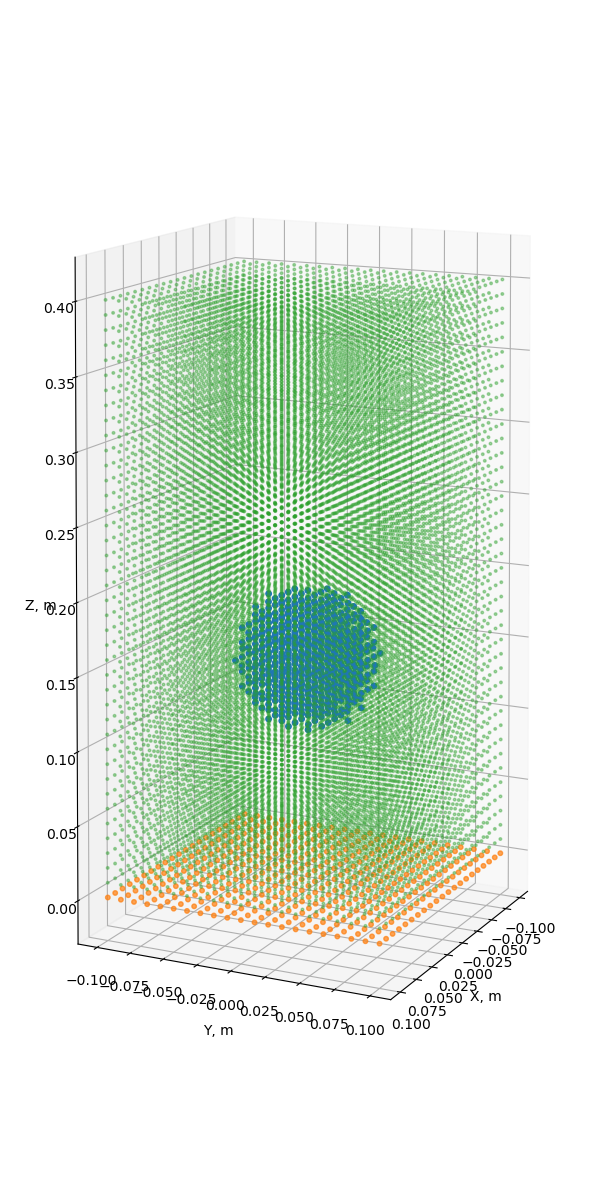

In [12]:
import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random
%matplotlib notebook


fig = pyplot.figure(figsize=(6,12))
ax = Axes3D(fig)

ax.view_init(elev=-0., azim=0)
ax.scatter(world.x0[0] + xsph*world.dh[0], world.x0[1] + ysph*world.dh[1], world.x0[2] + zsph*world.dh[2], s=15.5, alpha=1.0)
ax.scatter(world.x0[0] + xinl*world.dh[0], world.x0[1] + yinl*world.dh[1], world.x0[2] + zinl*world.dh[2], s=10.5, alpha=0.7)
ax.scatter(world.x0[0] + xres*world.dh[0], world.x0[1] + yres*world.dh[1], world.x0[2] + zres*world.dh[2], s=3.5, alpha=0.4)

ax.auto_scale_xyz([-0.1, 0.1], [-0.1, 0.1], [0, 0.4])
ax.set_xlabel('X, m')
ax.set_ylabel('Y, m')
ax.set_zlabel('Z, m')
pyplot.show()

In [13]:
u    = np.where(world.object_id == 0)

In [14]:
np.shape(u)

(3, 17126)

In [15]:
u = np.asarray(u)

In [16]:
np.shape(u.T)

(17126, 3)

In [17]:
u.T

array([[ 0,  0,  1],
       [ 0,  0,  2],
       [ 0,  0,  3],
       ...,
       [20, 20, 38],
       [20, 20, 39],
       [20, 20, 40]])

In [18]:
u.T[:,2]

array([ 1,  2,  3, ..., 38, 39, 40])

In [19]:
world.phi[u.T[0,0], u.T[0,1], u.T[0,2] ]

0.0

In [21]:
world=World(21,21,41)
world.setTime(1E-7,400)
world.setExtents(-0.1, -0.1, 0.0 , 0.1, 0.1, 0.4)

world.addSphere(np.array([0.0,0.0,0.15]), 0.05, -100.0)
world.addInlet(0.0)
world.markBoundaryCells()
world.potentialSolver8(1.4, 30000, 1E-4, 1E12, 0.0, 1.0)

iter: 25, L2 = 14050.595422000637
iter: 50, L2 = 9436.255383629012
iter: 75, L2 = 7591.564120328259
iter: 100, L2 = 6448.915299504057
iter: 125, L2 = 5608.110554576964
iter: 150, L2 = 4940.961701485898
iter: 175, L2 = 4393.07575656449
iter: 200, L2 = 3935.7096701791625
iter: 225, L2 = 3550.9521938113708
iter: 250, L2 = 3226.273915769033
iter: 275, L2 = 2952.144712841206
iter: 300, L2 = 2720.835722922955
iter: 325, L2 = 2525.7897613642567
iter: 350, L2 = 2361.311440013336
iter: 375, L2 = 2222.4289909955532
iter: 400, L2 = 2104.827713809852
iter: 425, L2 = 2004.8009338321808
iter: 450, L2 = 1919.1992383886854
iter: 475, L2 = 1845.3754593489305
iter: 500, L2 = 1781.1274486506143
iter: 525, L2 = 1724.640949284306
iter: 550, L2 = 1674.4344618124142
iter: 575, L2 = 1629.3076601824987
iter: 600, L2 = 1588.2945255771913
iter: 625, L2 = 1550.6219032668998
iter: 650, L2 = 1515.673719673362
iter: 675, L2 = 1482.9607088316277
iter: 700, L2 = 1452.0952293044097
iter: 725, L2 = 1422.7706028059856
it

iter: 5900, L2 = 35.00874435794742
iter: 5925, L2 = 34.38952505987268
iter: 5950, L2 = 33.781258240976264
iter: 5975, L2 = 33.18375017859032
iter: 6000, L2 = 32.59681057656925
iter: 6025, L2 = 32.02025250461928
iter: 6050, L2 = 31.453892338777393
iter: 6075, L2 = 30.897549702931787
iter: 6100, L2 = 30.35104741146152
iter: 6125, L2 = 29.814211412629344
iter: 6150, L2 = 29.286870733286186
iter: 6175, L2 = 28.76885742443172
iter: 6200, L2 = 28.260006507572808
iter: 6225, L2 = 27.76015592238224
iter: 6250, L2 = 27.269146474898324
iter: 6275, L2 = 26.78682178699656
iter: 6300, L2 = 26.313028246428544
iter: 6325, L2 = 25.84761495802862
iter: 6350, L2 = 25.390433695543333
iter: 6375, L2 = 24.941338854541215
iter: 6400, L2 = 24.500187405931424
iter: 6425, L2 = 24.066838850464023
iter: 6450, L2 = 23.64115517400238
iter: 6475, L2 = 23.223000803534045
iter: 6500, L2 = 22.812242563980096
iter: 6525, L2 = 22.408749635826165
iter: 6550, L2 = 22.01239351346238
iter: 6575, L2 = 21.623047964166197
iter

iter: 11650, L2 = 0.577556630934427
iter: 11675, L2 = 0.5673410629492724
iter: 11700, L2 = 0.5573061834667961
iter: 11725, L2 = 0.5474487965114856
iter: 11750, L2 = 0.5377657626988045
iter: 11775, L2 = 0.528253998114581
iter: 11800, L2 = 0.5189104734540915
iter: 11825, L2 = 0.5097322129542232
iter: 11850, L2 = 0.5007162934882565
iter: 11875, L2 = 0.49185984364679247
iter: 11900, L2 = 0.48316004281594144
iter: 11925, L2 = 0.47461412022738364
iter: 11950, L2 = 0.4662193541548328
iter: 11975, L2 = 0.45797307102046114
iter: 12000, L2 = 0.4498726445286833
iter: 12025, L2 = 0.44191549481960407
iter: 12050, L2 = 0.4340990876828558
iter: 12075, L2 = 0.42642093371129003
iter: 12100, L2 = 0.41887858756269136
iter: 12125, L2 = 0.41146964711936856
iter: 12150, L2 = 0.4041917527526719
iter: 12175, L2 = 0.39704258658097213
iter: 12200, L2 = 0.3900198717409162
iter: 12225, L2 = 0.383121371569878
iter: 12250, L2 = 0.376344889051333
iter: 12275, L2 = 0.36968826597827875
iter: 12300, L2 = 0.363149382345

iter: 17150, L2 = 0.011389802219830051
iter: 17175, L2 = 0.011188344395623438
iter: 17200, L2 = 0.010990449880017829
iter: 17225, L2 = 0.0107960556194972
iter: 17250, L2 = 0.010605099739355556
iter: 17275, L2 = 0.010417521386992482
iter: 17300, L2 = 0.01023326085616468
iter: 17325, L2 = 0.010052259422278734
iter: 17350, L2 = 0.009874459467710418
iter: 17375, L2 = 0.009699804385515952
iter: 17400, L2 = 0.009528238493770689
iter: 17425, L2 = 0.009359707208671896
iter: 17450, L2 = 0.00919415680771772
iter: 17475, L2 = 0.009031534594666402
iter: 17500, L2 = 0.008871788780099412
iter: 17525, L2 = 0.00871486848782002
iter: 17550, L2 = 0.008560723722423188
iter: 17575, L2 = 0.008409305388181354
iter: 17600, L2 = 0.00826056530614844
iter: 17625, L2 = 0.00811445605250536
iter: 17650, L2 = 0.007970931123041192
iter: 17675, L2 = 0.007829944789924772
iter: 17700, L2 = 0.007691452165930388
iter: 17725, L2 = 0.007555409139180303
iter: 17750, L2 = 0.007421772373302267
iter: 17775, L2 = 0.007290499327

iter: 22400, L2 = 0.00026849818290675944
iter: 22425, L2 = 0.0002637491010774131
iter: 22450, L2 = 0.00025908403417050055
iter: 22475, L2 = 0.00025450144509961306
iter: 22500, L2 = 0.00024999996047002837
iter: 22525, L2 = 0.0002455780685524402
iter: 22550, L2 = 0.00024123439811052773
iter: 22575, L2 = 0.0002369675416811069
iter: 22600, L2 = 0.00023277615882200378
iter: 22625, L2 = 0.00022865891932106252
iter: 22650, L2 = 0.00022461450389645038
iter: 22675, L2 = 0.00022064161707159759
iter: 22700, L2 = 0.0002167389994639294
iter: 22725, L2 = 0.00021290543543569309
iter: 22750, L2 = 0.00020913964722658822
iter: 22775, L2 = 0.00020544048869782793
iter: 22800, L2 = 0.00020180674110361092
iter: 22825, L2 = 0.000198237275421954
iter: 22850, L2 = 0.00019473092443776083
iter: 22875, L2 = 0.00019128661783462798
iter: 22900, L2 = 0.00018790321958649082
iter: 22925, L2 = 0.0001845796627398738
iter: 22950, L2 = 0.00018131490026574508
iter: 22975, L2 = 0.00017810789149042003
iter: 23000, L2 = 0.000

True

<IPython.core.display.Javascript object>


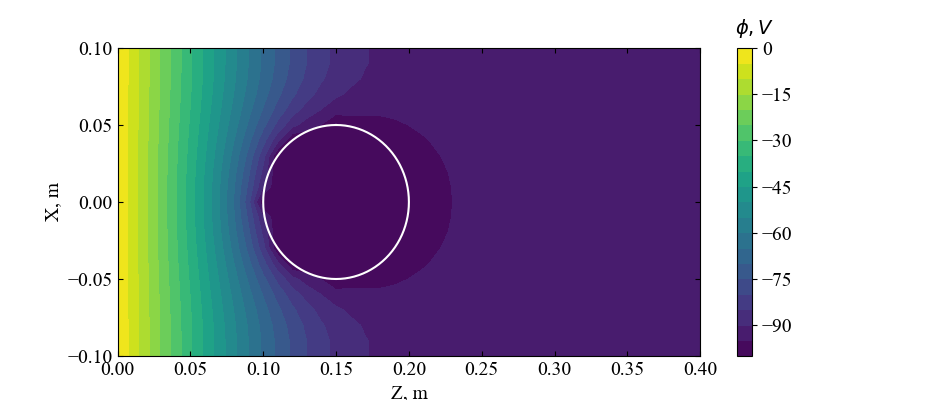

In [23]:
import matplotlib.pyplot as plt

x = np.linspace(-0.1,0.1,21)
z = np.linspace(0.0, 0.4, 41)

zgrid, xgrid = np.meshgrid(z,x)

plt.figure(figsize=(9.4,4))
plt.rc('font',family='Times New Roman')
plt.contourf(zgrid,xgrid,world.phi[:,10,:], levels=21)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\phi, V$', labelpad=-27, y=1.10, rotation=0, fontsize=14)

x0 = 0
z0 = 0.15

r0 = 0.05

theta =np.linspace(0,2*np.pi,101)

x1 = x0 + r0*np.cos(theta)
z1 = z0 + r0*np.sin(theta)

plt.plot(z1,x1,'w-')

ax = plt.gca()
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.tick_params(direction='in')
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)

plt.xlabel('Z, m',fontsize=14)
plt.ylabel("X, m",fontsize=14)

plt.savefig("initial-potential.png", dpi=200, bbox_inches='tight')

plt.show()

In [86]:
class Particle:
    """
    The Particle class encapsulates information about the particles 
    used in the simulation.
    
    Attributes
    ----------
    
    ----------
    
    """
    
    def __init__(self, pos, vel, mpw):
        """
        Initializes the Particle object with the position, 
        speed, and macrparticle weight.

        Parameters
        ----------
        pos : numpy.ndarray
            particle position vector
        vel : numpy.ndarray
            particle velocity vector
        mpw : float
            macroparticle weight  
        ----------
        
        """
        
        self.pos = pos
        self.vel = vel
        self.mpw = mpw
        

class Species:
    """
    The Species class encapsulates information about the species 
    used in the simulation.
    
    Attributes
    ----------
    
    ----------
    
    """
    def __init__(self, name, mass, charge, mpw0, worldObj):
        """
        Initializes the Species object with the name, mass,
        charge.

        Parameters
        ----------
        name : str
            species name
        mass : float
            species mass
        charge : float
            species charge
        mpw : float
            macroparticle weight  
        ----------

        """
        
        self.particleList = []
        
        self.name   = name
        self.mass   = mass
        self.charge = charge
        self.mpw0   = mpw0
        
        self.den    = np.zeros((worldObj.ni, worldObj.nj, worldObj.nk))
        
        self.worldObj = worldObj
        
    def ColdBeamSource(self, v_drift, den):
        """
        Cold beam source

        Parameters
        ----------
        v_drift : float
            drift speed
        den : float
            number density
        ----------
        
        """
        
        Lx = self.worldObj.dh[0]*(self.worldObj.ni-1)
        Ly = self.worldObj.dh[1]*(self.worldObj.nj-1)
        
        A   = Lx*Ly
        
        num_real = den*v_drift*A*self.worldObj.dt
        
        num_sim  = int(num_real / self.mpw0 + random.random())
        
        for i in range(0, num_sim):
            pos = np.zeros(3)
            vel = np.zeros(3)
            
            pos[0] = self.worldObj.x0[0] + random.random()*Lx
            pos[1] = self.worldObj.x0[1] + random.random()*Ly
            pos[2] = self.worldObj.x0[2]
            
            vel[0] = 0.0
            vel[1] = 0.0
            vel[2] = v_drift
            
            self.addParticle(pos,vel,self.mpw0)     
        
    
    def addParticle(self, pos, vel, mpw):
        """random.random()
        add a particle to particleList

         Parameters
        ----------
        pos : numpy.ndarray
            particle position vector
        vel : numpy.ndarray
            particle velocity vector
        mpw : float
            macroparticle weight  
        ----------
        
        """
        #get logical coordinate of particle's position
        lc = self.worldObj.XtoL(pos)

        #electric field at particle position
        ef_part = self.gather_ef(lc)

        #rewind velocity back by 0.5*dt*ef
        vel -=  self.charge/self.mass*ef_part*(0.5*self.worldObj.dt);
        
        #add particle to list
        self.particleList.append(Particle(pos, vel, mpw))
        
        
    def loadParticlesBox(self, x1, x2, num_den, num_mp):
        """
        loads randomly distributed particles in a x1-x2 box 
        representing num_den number density

        Parameters
        ----------
        x1 : numpy.ndarray
            origin of bounding box
        x2 : numpy.ndarray
            max. bound corner of box
        num_den : float
            number density
        num_mp  : number of macroparticles
        ----------

        """
        box_vol  = (x2[0]-x1[0])*(x2[1]-x1[1])*(x2[2]-x1[2]) # box vol.
        num_real = num_den * box_vol;                   #number of real particles
        mpw      = num_real/num_mp;                     # macroparticle weight
        
        self.box_vol = box_vol
        self.num_real= num_real
        self.mpw     = mpw

        #load particles on an equally spaced grid
        for p in np.arange(0,num_mp+1):
            # sample random position
            pos = np.zeros(3)
            vel = np.zeros(3)

            #rnd = random.random()

            pos[0] = x1[0] + random.random()*(x2[0]-x1[0]);
            pos[1] = x1[1] + random.random()*(x2[1]-x1[1]);
            pos[2] = x1[2] + random.random()*(x2[2]-x1[2]);

            #set initial velocity
            vel[0] = 0.0
            vel[1] = 0.0
            vel[2] = 0.0

            self.addParticle(pos,vel,mpw); # add new particle
            
    def loadParticlesBoxQS(self, x1, x2, num_den, num_mp):
        """
        loads randomly distributed particles in a x1-x2 box 
        representing num_den number density

        Parameters
        ----------
        x1 : numpy.ndarray
            origin of bounding box
        x2 : numpy.ndarray
            max. bound corner of box
        num_den : float
            number density
        num_mp  : numpy.ndarray
        ----------

        """
        box_vol  = (x2[0]-x1[0])*(x2[1]-x1[1])*(x2[2]-x1[2]) # box vol.
        num_real = num_den * box_vol;                   #number of real particles
        num_mp_tot = (num_mp[0]-1)*(num_mp[1]-1)*(num_mp[2]-1)
        mpw      = num_real/num_mp_tot;                     # macroparticle weight
        
        self.box_vol = box_vol
        self.num_real= num_real
        self.mpw     = mpw
        
        di = (x2[0]-x1[0])/(num_mp[0]-1);
        dj = (x2[1]-x1[1])/(num_mp[1]-1);
        dk = (x2[2]-x1[2])/(num_mp[2]-1);

        #load particles on a equally spaced grid
        
        for i in np.arange(0,num_mp[0]):
            for j in np.arange(0,num_mp[1]):
                for k in np.arange(0,num_mp[2]):
                    
                    # sample random position
                    pos = np.zeros(3)
                    vel = np.zeros(3)
                    
                    pos[0] = x1[0] + i*di;
                    pos[1] = x1[1] + j*dj;
                    pos[2] = x1[2] + k*dk;

                    # shift particles on max faces back to the domain
                    if (pos[0]==x2[0]): pos[0]-=1e-4*di;
                    if (pos[1]==x2[1]): pos[1]-=1e-4*dj;
                    if (pos[2]==x2[2]): pos[2]-=1e-4*dk;

                    w = 1;
                    if (i==0 or i==num_mp[0]-1): w*=0.5
                    if (j==0 or j==num_mp[1]-1): w*=0.5
                    if (k==0 or k==num_mp[2]-1): w*=0.5

                    #set initial velocity
                    vel[0] = 0.0
                    vel[1] = 0.0
                    vel[2] = 0.0

                    self.addParticle(pos,vel,mpw*w)
                    
    
    def scatter_den(self, lc, value):
        """
        scatters scalar value onto a field at logical coordinate lc

        Parameters
        ----------
        lc : numpy.ndarray
            logical coordinate 
        ----------
        """
        
        if lc [0] < 0 or \
             lc [0] >=self.worldObj.ni-1 or \
             lc [1] < 0 or \
             lc [1] >=self.worldObj.nj-1 or \
             lc [2] < 0 or \
             lc [2] >=self.worldObj.nk-1:
            
            print("WARNING: point outside domain")
             
        i  = int(lc[0])
        di = lc[0]-i

        j  = int(lc[1])
        dj = lc[1]-j

        k  = int(lc[2])
        dk = lc[2]-k

        self.den[i][j][k]      += value*(1-di)*(1-dj)*(1-dk)
        self.den[i+1][j][k]    += value*(di)*(1-dj)*(1-dk)
        self.den[i+1][j+1][k]  += value*(di)*(dj)*(1-dk)
        self.den[i][j+1][k]    += value*(1-di)*(dj)*(1-dk)
        self.den[i][j][k+1]    += value*(1-di)*(1-dj)*(dk)
        self.den[i+1][j][k+1]  += value*(di)*(1-dj)*(dk)
        self.den[i+1][j+1][k+1]+= value*(di)*(dj)*(dk)
        self.den[i][j+1][k+1]  += value*(1-di)*(dj)*(dk)
    
    
    def scatter_den2(self, lc, value):
        """
        scatters scalar value onto a field at logical coordinate lc

        Parameters
        ----------
        lc : numpy.ndarray
            logical coordinate 
        ----------
        """
        
        
        if lc [:,0].any() < 0 or \
             lc [:,0].any() >=self.worldObj.ni-1 or \
             lc [:,1].any() < 0 or \
             lc [:,1].any() >=self.worldObj.nj-1 or \
             lc [:,2].any() < 0 or \
             lc [:,2].any() >=self.worldObj.nk-1:
            
            print("WARNING: point outside domain")
             
        i  = lc[:,0].astype(int)
        di = lc[:,0]-i

        j  = lc[:,1].astype(int)
        dj = lc[:,1]-j

        k  = lc[:,2].astype(int)
        dk = lc[:,2]-k
        
        self.den2 = np.zeros((self.worldObj.ni, self.worldObj.nj, self.worldObj.nk, len(self.particleList)), np.dtype('f4')) 
        
        self.den2[i,j,k,:]      = value*(1-di)*(1-dj)*(1-dk)
        self.den2[i+1,j,k,:]    = value*(di)*(1-dj)*(1-dk)
        self.den2[i+1,j+1,k,:]  = value*(di)*(dj)*(1-dk)
        self.den2[i,j+1,k,:]    = value*(1-di)*(dj)*(1-dk)
        self.den2[i,j,k+1,:]    = value*(1-di)*(1-dj)*(dk)
        self.den2[i+1,j,k+1,:]  = value*(di)*(1-dj)*(dk)
        self.den2[i+1,j+1,k+1,:]= value*(di)*(dj)*(dk)
        self.den2[i,j+1,k+1,:]  = value*(1-di)*(dj)*(dk)
        
        for i in np.arange(0, self.worldObj.ni):
            for j in np.arange(0, self.worldObj.nj):
                for k in np.arange(0, self.worldObj.nk):
                    self.den[i,j,k] = np.sum(self.den2[i,j,k][:])
        
        
    
    
    def computeNumberDensity(self):
        """
        Compute particle number density

        Parameters
        ----------
        
        ----------
        """
        self.den = np.zeros((self.worldObj.ni, self.worldObj.nj, self.worldObj.nk))
        
        for particle in self.particleList:
            lc = self.worldObj.XtoL(particle.pos)
            self.scatter_den(lc, self.mpw0)
            
        self.den = self.den / self.worldObj.node_vol
    
    def computeNumberDensity3(self):
        """
        Compute particle number density

        Parameters
        ----------
        
        ----------
        """
        self.den = np.zeros((self.worldObj.ni, self.worldObj.nj, self.worldObj.nk))
        
        #for particle in self.particleList:
        
        pos_vec = np.zeros((len(self.particleList),3))
        
        for i in range(len(self.particleList)):
            pos_vec[i,:] = (self.particleList[i]).pos
        
        #get logical coordinate of particle's position
        lc = self.worldObj.XtoLvec(pos_vec)
        
        for i in range(len(self.particleList)):
            self.scatter_den(lc[i,:], self.mpw)
            
        self.den = self.den / self.worldObj.node_vol
    
    
    def computeNumberDensity4(self):
        """
        Compute particle number density

        Parameters
        ----------
        
        ----------
        """
        self.den = np.zeros((self.worldObj.ni, self.worldObj.nj, self.worldObj.nk))
        
        pos_vec2 = np.zeros((len(self.particleList),3))
        
        #for i in range(len(self.particleList)):
        #    pos_vec[i,:] = (self.particleList[i]).pos
        
        pos_vec2 = [(species1.particleList[i]).pos for i in range(len(species1.particleList))]
        
        pos_vec = np.asarray(pos_vec2)

        #get logical coordinate of particle's position
        lc = self.worldObj.XtoLvec(pos_vec)
        
        for i in range(len(self.particleList)):
            self.scatter_den(lc[i,:], self.mpw)
            
        self.den = self.den / self.worldObj.node_vol

    
    def computeNumberDensity2(self):
        """
        Compute particle number density

        Parameters
        ----------
        
        ----------
        """
        self.den = np.zeros((self.worldObj.ni, self.worldObj.nj, self.worldObj.nk))
        
        #for particle in self.particleList:
        
        pos_vec = np.zeros((len(self.particleList),3))
        
        for i in range(len(self.particleList)):
            pos_vec[i,:] = (self.particleList[i]).pos
        
        #get logical coordinate of particle's position
        lc = self.worldObj.XtoLvec(pos_vec)

        self.scatter_den2(lc, self.mpw)

        self.den = self.den / self.worldObj.node_vol
        
    
    def gather_ef(self, lc):
        """
        gathers field value at logical coordinate lc

        Parameters
        ----------
        lc : numpy.ndarray
            logical coordinate 
        data : numpy.ndarray
            electric field array
        ----------
        """
        
        if lc [0] < 0 or \
             lc [0] >=self.worldObj.ni-1 or \
             lc [1] < 0 or \
             lc [1] >=self.worldObj.nj-1 or \
             lc [2] < 0 or \
             lc [2] >=self.worldObj.nk-1:
            
            print("WARNING: point outside domain")
             
        i  = int(lc[0])
        di = lc[0]-i

        j  = int(lc[1])
        dj = lc[1]-j

        k  = int(lc[2])
        dk = lc[2]-k

        # gather electric field onto particle position
         
        ef_x  = self.worldObj.ef[i][j][k][0]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j][k][0]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j+1][k][0]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j+1][k][0]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j][k+1][0]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j][k+1][0]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j+1][k+1][0]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i][j+1][k+1][0]*(1-di)*(dj)*(dk)
        
        ef_y  = self.worldObj.ef[i][j][k][1]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j][k][1]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j+1][k][1]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j+1][k][1]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j][k+1][1]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j][k+1][1]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j+1][k+1][1]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i][j+1][k+1][1]*(1-di)*(dj)*(dk)
        
        ef_z  = self.worldObj.ef[i][j][k][2]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j][k][2]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j+1][k][2]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j+1][k][2]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j][k+1][2]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j][k+1][2]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j+1][k+1][2]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i][j+1][k+1][2]*(1-di)*(dj)*(dk)
        
        ef_part = np.array([ef_x, ef_y, ef_z])
        
        return ef_part
    
    def gather_ef2(self, lc):
        """
        gathers field value at logical coordinate lc

        Parameters
        ----------
        lc : numpy.ndarray
            logical coordinate 
        data : numpy.ndarray
            electric field array
        ----------
        """
        
        if lc [:,0].any() < 0 or \
             lc [:,0].any() >=self.worldObj.ni-1 or \
             lc [:,1].any() < 0 or \
             lc [:,1].any() >=self.worldObj.nj-1 or \
             lc [:,2].any() < 0 or \
             lc [:,2].any() >=self.worldObj.nk-1:
            
            print("WARNING: point outside domain")
             
        i  = lc[:,0].astype(int)
        di = lc[:,0]-i

        j  = lc[:,1].astype(int)
        dj = lc[:,1]-j

        k  = lc[:,2].astype(int)
        dk = lc[:,2]-k

        # gather electric field onto particle position
        
        ef = np.zeros((len(lc[:,0]),3))
        
        ef[:,0]  = self.worldObj.ef[i,j,k][:,0]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1,j,k][:,0]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1,j+1,k][:,0]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i,j+1,k][:,0]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i,j,k+1][:,0]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1,j,k+1][:,0]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1,j+1,k+1][:,0]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i,j+1,k+1][:,0]*(1-di)*(dj)*(dk)
        
        ef[:,1]  = self.worldObj.ef[i,j,k][:,1]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1,j,k][:,1]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1,j+1,k][:,1]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i,j+1,k][:,1]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i,j,k+1][:,1]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1,j,k+1][:,1]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1,j+1,k+1][:,1]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i,j+1,k+1][:,1]*(1-di)*(dj)*(dk)
        
        ef[:,2]  = self.worldObj.ef[i,j,k][:,2]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1,j,k][:,2]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1,j+1,k][:,2]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i,j+1,k][:,2]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i,j,k+1][:,2]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1,j,k+1][:,2]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1,j+1,k+1][:,2]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i,j+1,k+1][:,2]*(1-di)*(dj)*(dk)
        
        
        return ef
    
    
    def advance(self):
        #get the time step
        dt = self.worldObj.dt

        #save mesh bounds
        x0 = self.worldObj.x0
        xm = self.worldObj.xm

        # loop over all particles
        for particle in self.particleList:
        
            #get logical coordinate of particle's position
            lc = self.worldObj.XtoL(particle.pos)

            #electric field at particle position
            ef_part = self.gather_ef(lc)

            #update velocity from F=qE
            particle.vel += ef_part*(dt*self.charge/self.mass)

            #update position from v=dx/dt
            particle.pos += particle.vel*dt

            if self.worldObj.inSphere(particle.pos) or self.worldObj.inBounds(particle.pos)==False:
                particle.mpw = 0.0
                
        npp = len(self.particleList)

        p = 0

        while p < npp:
                if self.particleList[p].mpw == 0:
                    del self.particleList[p]

                    npp = npp - 1
                    p  = p - 1

                p = p+1
                    
    def advance2(self):
        #get the time step
        dt = self.worldObj.dt

        #save mesh bounds
        x0 = self.worldObj.x0
        xm = self.worldObj.xm

        # loop over all particles
        # for particle in self.particleList:
        
        pos_vec = np.zeros((len(self.particleList),3))
        
        for i in range(len(self.particleList)):
            pos_vec[i,:] = (self.particleList[i]).pos
        
        
        
        #get logical coordinate of particle's position
        lc = self.worldObj.XtoLvec(pos_vec)

        #electric field at particle position
        ef = self.gather_ef2(lc)

        #update velocity from F=qE
        for i in range(len(self.particleList)):
            self.particleList[i].vel += ef[i,:]*(dt*self.charge/self.mass)
        
        #update position from v=dx/dt
        for i in range(len(self.particleList)):
            self.particleList[i].pos += self.particleList[i].vel*dt
        
        #did this particle leave the domain? reflect back
        for particle in self.particleList:
            for i in np.arange(3):

                if particle.pos[i] < x0[i]:
                    particle.pos[i]=2*x0[i]-particle.pos[i]
                    particle.vel[i]*=-1.0

                elif particle.pos[i] >= xm[i]:
                    particle.pos[i]=2*xm[i]-particle.pos[i]
                    particle.vel[i]*=-1.0
                    
    def advance3(self):
        #get the time step
        dt = self.worldObj.dt

        #save mesh bounds
        x0 = self.worldObj.x0
        xm = self.worldObj.xm

        # loop over all particles
        # for particle in self.particleList:
        
        pos_vec2 = np.zeros((len(self.particleList),3))
        
        #for i in range(len(self.particleList)):
        #    pos_vec[i,:] = (self.particleList[i]).pos
        
        pos_vec2 = [(species1.particleList[i]).pos for i in range(len(species1.particleList))]
        
        pos_vec = np.asarray(pos_vec2)

        
        #get logical coordinate of particle's position
        lc = self.worldObj.XtoLvec(pos_vec)

        #electric field at particle position
        ef = self.gather_ef2(lc)

        #update velocity from F=qE
        for i in range(len(self.particleList)):
            self.particleList[i].vel += ef[i,:]*(dt*self.charge/self.mass)
        
        #update position from v=dx/dt
        for i in range(len(self.particleList)):
            self.particleList[i].pos += self.particleList[i].vel*dt
        
        #is p

In [32]:
world=World(21,21,41)
world.setTime(1E-7,400)
world.setExtents(-0.1, -0.1, 0.0 , 0.1, 0.1, 0.4)

world.addSphere(np.array([0.0,0.0,0.15]), 0.05, -100.0)
world.addInlet(0.0)
world.markBoundaryCells()

species1 = Species("O+", 16*world.AMU, world.QE, 1E4, world)

world.addSpeciesList([species1])

species1.computeNumberDensity()

world.computeChargeDensity()

world.potentialSolver8(1.4, 30000, 1E-4, 1E12, 0.0, 1.0)

world.efSolver2()

for i in range(1,11):
    
    print("ts = "+str(i)+", nO+: "+str(len(species1.particleList)))
    
    species1.ColdBeamSource(7000.0, 1E12)
    species1.advance()
    species1.computeNumberDensity()
    
    world.computeChargeDensity()
    
    world.potentialSolver8(1.4, 30000, 1E-4, 1E12, 0.0, 1.0)
    
    world.efSolver2()
    

    

ts = 1, nO+: 0
ts = 2, nO+: 2800
ts = 3, nO+: 5600
ts = 4, nO+: 8400
ts = 5, nO+: 11200
ts = 6, nO+: 14000
ts = 7, nO+: 16800
ts = 8, nO+: 19600
ts = 9, nO+: 22400
ts = 10, nO+: 25200


In [33]:
x_arr1 = np.zeros(len(species1.particleList))
y_arr1 = np.zeros(len(species1.particleList))
z_arr1 = np.zeros(len(species1.particleList))

for j in np.arange(0,len(species1.particleList)):
            pos = species1.particleList[j].pos
            x_arr1[j] = pos[0]
            y_arr1[j] = pos[1]
            z_arr1[j] = pos[2]

<IPython.core.display.Javascript object>


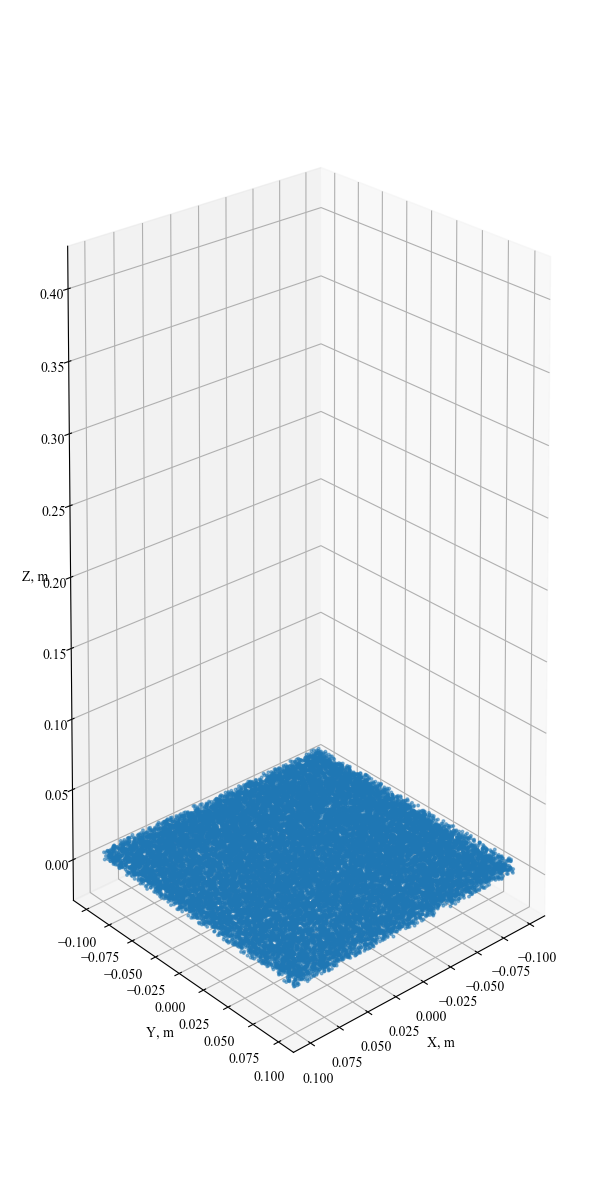

Text(0.5, 0, 'Z, m')

In [39]:
fig = pyplot.figure(figsize=(6,12))
ax = Axes3D(fig)

ax.view_init(elev=-0., azim=0)

ax.scatter(x_arr1, y_arr1, z_arr1, s=3.5, alpha=0.5)
ax.auto_scale_xyz([-0.1, 0.1], [-0.1, 0.1], [0, 0.4])
ax.set_xlabel('X, m')
ax.set_ylabel('Y, m')
ax.set_zlabel('Z, m')

<IPython.core.display.Javascript object>


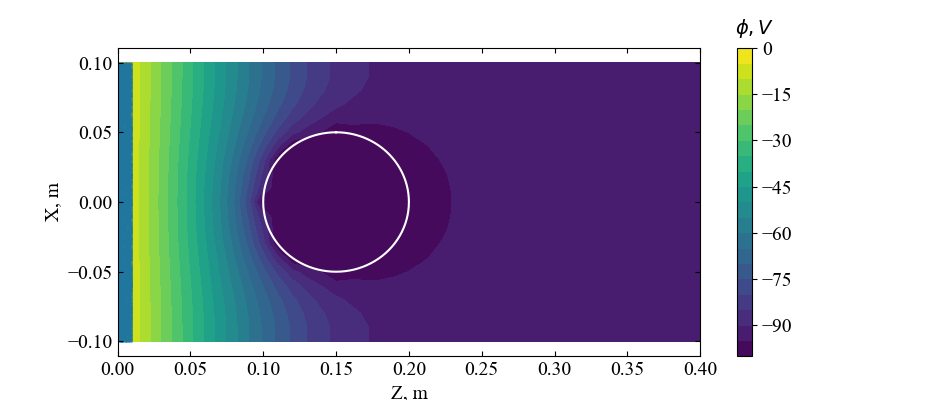

In [35]:
import matplotlib.pyplot as plt

x = np.linspace(-0.1,0.1,21)
z = np.linspace(0.0, 0.4, 41)

zgrid, xgrid = np.meshgrid(z,x)

plt.figure(figsize=(9.4,4))
plt.rc('font',family='Times New Roman')
plt.contourf(zgrid,xgrid,world.phi[:,10,:], levels=21)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\phi, V$', labelpad=-27, y=1.10, rotation=0, fontsize=14)

x0 = 0
z0 = 0.15

r0 = 0.05

theta =np.linspace(0,2*np.pi,101)

x1 = x0 + r0*np.cos(theta)
z1 = z0 + r0*np.sin(theta)

plt.plot(z1,x1,'w-')

ax = plt.gca()
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.tick_params(direction='in')
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)

plt.xlabel('Z, m',fontsize=14)
plt.ylabel("X, m",fontsize=14)

ax.scatter(z_arr1, x_arr1, s=1.5, alpha=0.)

plt.show()

In [40]:
world=World(21,21,41)
world.setTime(1E-7,400)
world.setExtents(-0.1, -0.1, 0.0 , 0.1, 0.1, 0.4)

world.addSphere(np.array([0.0,0.0,0.15]), 0.05, -100.0)
world.addInlet(0.0)
world.markBoundaryCells()

species1 = Species("O+", 16*world.AMU, world.QE, 1E4, world)

world.addSpeciesList([species1])

species1.computeNumberDensity()

world.computeChargeDensity()

world.potentialSolver8(1.4, 30000, 1E-4, 1E12, 0.0, 1.0)

world.efSolver2()

for i in range(1,101):
    
    print("ts = "+str(i)+", nO+: "+str(len(species1.particleList)))
    
    species1.ColdBeamSource(7000.0, 1E12)
    species1.advance()
    species1.computeNumberDensity()
    
    world.computeChargeDensity()
    
    world.potentialSolver8(1.4, 30000, 1E-4, 1E12, 0.0, 1.0)
    
    world.efSolver2()

ts = 1, nO+: 0
ts = 2, nO+: 2800
ts = 3, nO+: 5600
ts = 4, nO+: 8400
ts = 5, nO+: 11200
ts = 6, nO+: 14000
ts = 7, nO+: 16800
ts = 8, nO+: 19600
ts = 9, nO+: 22400
ts = 10, nO+: 25200
ts = 11, nO+: 28000
ts = 12, nO+: 30800
ts = 13, nO+: 33600
ts = 14, nO+: 36400
ts = 15, nO+: 39200
ts = 16, nO+: 42000
ts = 17, nO+: 44800
ts = 18, nO+: 47600
ts = 19, nO+: 50400


IndexError: list index out of range

<IPython.core.display.Javascript object>


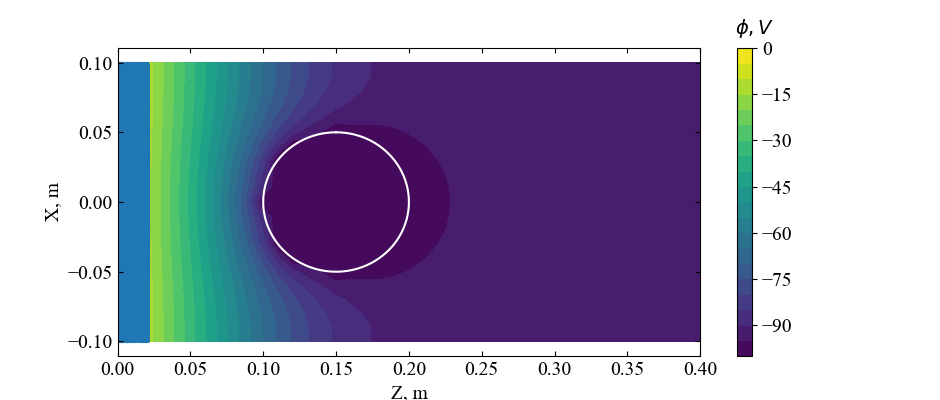

In [43]:
x_arr1 = np.zeros(len(species1.particleList))
y_arr1 = np.zeros(len(species1.particleList))
z_arr1 = np.zeros(len(species1.particleList))

for j in np.arange(0,len(species1.particleList)):
            pos = species1.particleList[j].pos
            x_arr1[j] = pos[0]
            y_arr1[j] = pos[1]
            z_arr1[j] = pos[2]
            
import matplotlib.pyplot as plt

x = np.linspace(-0.1,0.1,21)
z = np.linspace(0.0, 0.4, 41)

zgrid, xgrid = np.meshgrid(z,x)

plt.figure(figsize=(9.4,4))
plt.rc('font',family='Times New Roman')
plt.contourf(zgrid,xgrid,world.phi[:,10,:], levels=21)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\phi, V$', labelpad=-27, y=1.10, rotation=0, fontsize=14)

x0 = 0
z0 = 0.15

r0 = 0.05

theta =np.linspace(0,2*np.pi,101)

x1 = x0 + r0*np.cos(theta)
z1 = z0 + r0*np.sin(theta)

plt.plot(z1,x1,'w-')

ax = plt.gca()
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.tick_params(direction='in')
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)

plt.xlabel('Z, m',fontsize=14)
plt.ylabel("X, m",fontsize=14)

ax.scatter(z_arr1, x_arr1, s=1.5, alpha=0.5)

plt.show()

In [44]:
len(species1.particleList)

53199

In [45]:
range(0,10)

range(0, 10)

In [46]:
range(10)

range(0, 10)

In [47]:
del species1.particleList[11]

In [48]:
len(species1.particleList)

53198

In [49]:
species1.particleList[10].mpw

10000.0

In [50]:
for i in np.arange(0, len(species1.particleList)):
            if species1.particleList[i].mpw == 0:
                del species1.particleList[i]

In [51]:
len(species1.particleList)

53198

In [59]:
for i in range(0, len(species1.particleList)):
            if species1.particleList[i].mpw == 0:
                del species1.particleList[i]

AttributeError: 'float' object has no attribute 'mpw'

In [53]:
len(species1.particleList)

53198

In [54]:
species1.particleList[10] = 0.0

In [60]:
del species1.particleList[10]

In [61]:
for i in np.arange(0, len(species1.particleList)):
            if species1.particleList[i].mpw == 0:
                del species1.particleList[i]

In [62]:
len(species1.particleList)

53197

In [63]:
species1.particleList[10].mpw = 0.0

In [64]:
for i in np.arange(0, len(species1.particleList)):
            if species1.particleList[i].mpw == 0:
                del species1.particleList[i]

IndexError: list index out of range

In [65]:
for particle in species1.particleList:
            if particle.mpw == 0:
                del species1.particleList[i]

In [66]:
species1.particleList[10].mpw = 0.0

In [67]:
for particle in species1.particleList:
            if particle.mpw == 0:
                del species1.particleList[i]

IndexError: list assignment index out of range

In [68]:
np = len(species1.particleList)

p = 0

while p < np:
        if species1.particleList[p].mpw == 0:
            del species1.particleList[p]
            
            np = np - 1
            p  = p - 1
        
        p = p+1

In [69]:
species1.particleList[10].mpw 

10000.0

In [70]:
species1.particleList[10].mpw = 0.0

In [71]:
np = len(species1.particleList)

p = 0

while p < np:
        if species1.particleList[p].mpw == 0:
            del species1.particleList[p]
            
            np = np - 1
            p  = p - 1
        
        p = p+1

In [72]:
len(species1.particleList)

53194

In [73]:
species1.particleList[14].mpw = 0
species1.particleList[15].mpw = 0
species1.particleList[16].mpw = 0

In [74]:
np = len(species1.particleList)

p = 0

while p < np:
        if species1.particleList[p].mpw == 0:
            del species1.particleList[p]
            
            np = np - 1
            p  = p - 1
        
        p = p+1

In [75]:
len(species1.particleList)

53191

In [ ]:
world=World(21,21,41)
world.setTime(1E-7,400)
world.setExtents(-0.1, -0.1, 0.0 , 0.1, 0.1, 0.4)

world.addSphere(np.array([0.0,0.0,0.15]), 0.05, -100.0)
world.addInlet(0.0)
world.markBoundaryCells()

species1 = Species("O+", 16*world.AMU, world.QE, 1E4, world)

world.addSpeciesList([species1])

species1.computeNumberDensity()

world.computeChargeDensity()

world.potentialSolver8(1.4, 30000, 1E-4, 1E12, 0.0, 1.0)

world.efSolver2()

for i in range(1,101):
    
    print("ts = "+str(i)+", nO+: "+str(len(species1.particleList)))
    
    species1.ColdBeamSource(7000.0, 1E12)
    species1.advance()
    species1.computeNumberDensity()
    
    world.computeChargeDensity()
    
    world.potentialSolver8(1.4, 30000, 1E-4, 1E12, 0.0, 1.0)
    
    world.efSolver2()
    
    if i==1 or i%40==0:

        x_arr1 = np.zeros(len(species1.particleList))
        y_arr1 = np.zeros(len(species1.particleList))
        z_arr1 = np.zeros(len(species1.particleList))
        
        p_arr1 = np.zeros(len(species1.particleList))
        p_arr1 = np.zeros(len(species1.particleList))
        p_arr1 = np.zeros(len(species1.particleList))

        for j in np.arange(0,len(species1.particleList)):
            pos = species1.particleList[j].pos
            x_arr1[j] = pos[0]
            y_arr1[j] = pos[1]
            z_arr1[j] = pos[2]

        

        np.savetxt('0species_1_x_'+str(i).zfill(4)+'.txt', x_arr1, fmt='%1.4f')
        np.savetxt('0species_1_y_'+str(i).zfill(4)+'.txt', y_arr1, fmt='%1.4f')
        np.savetxt('0species_1_z_'+str(i).zfill(4)+'.txt', z_arr1, fmt='%1.4f')

        np.savetxt('0phi_'+str(i).zfill(4)+'.txt', world.phi, fmt='%1.4f')
        np.savetxt('0rho_'+str(i).zfill(4)+'.txt', world.rho, fmt='%1.4f')

<IPython.core.display.Javascript object>


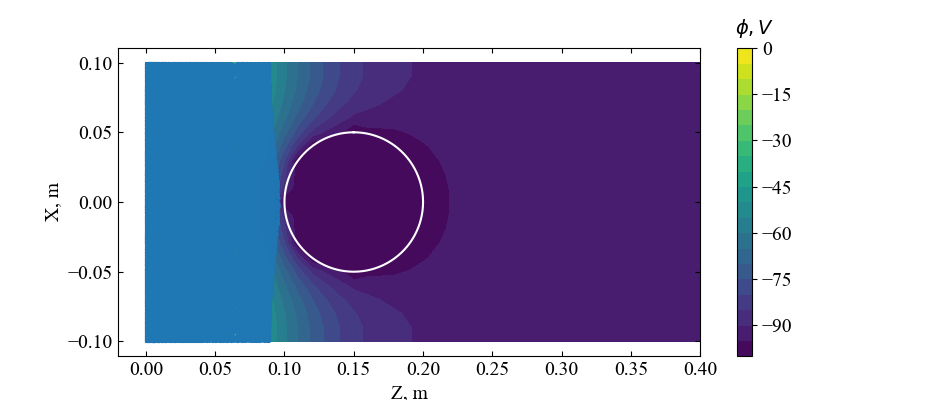

In [88]:
x_arr1 = np.zeros(len(species1.particleList))
y_arr1 = np.zeros(len(species1.particleList))
z_arr1 = np.zeros(len(species1.particleList))

for j in np.arange(0,len(species1.particleList)):
            pos = species1.particleList[j].pos
            x_arr1[j] = pos[0]
            y_arr1[j] = pos[1]
            z_arr1[j] = pos[2]
            
import matplotlib.pyplot as plt

x = np.linspace(-0.1,0.1,21)
z = np.linspace(0.0, 0.4, 41)

zgrid, xgrid = np.meshgrid(z,x)

plt.figure(figsize=(9.4,4))
plt.rc('font',family='Times New Roman')
plt.contourf(zgrid,xgrid,world.phi[:,10,:], levels=21)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\phi, V$', labelpad=-27, y=1.10, rotation=0, fontsize=14)

x0 = 0
z0 = 0.15

r0 = 0.05

theta =np.linspace(0,2*np.pi,101)

x1 = x0 + r0*np.cos(theta)
z1 = z0 + r0*np.sin(theta)

plt.plot(z1,x1,'w-')

ax = plt.gca()
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.tick_params(direction='in')
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)

plt.xlabel('Z, m',fontsize=14)
plt.ylabel("X, m",fontsize=14)

ax.scatter(z_arr1, x_arr1, s=1.5, alpha=0.5)

plt.show()

In [89]:
world=World(21,21,41)
world.setTime(1E-7,400)
world.setExtents(-0.1, -0.1, 0.0 , 0.1, 0.1, 0.4)

world.addSphere(np.array([0.0,0.0,0.15]), 0.05, -100.0)
world.addInlet(0.0)
world.markBoundaryCells()

species1 = Species("O+", 16*world.AMU, world.QE, 1E4, world)

world.addSpeciesList([species1])

species1.computeNumberDensity()

world.computeChargeDensity()

world.potentialSolver8(1.4, 30000, 1E-4, 1E12, 0.0, 1.0)

world.efSolver2()

for i in range(1,101):
    
    print("ts = "+str(i)+", nO+: "+str(len(species1.particleList)))
    
    species1.ColdBeamSource(7000.0, 1E12)
    species1.advance()
    species1.computeNumberDensity()
    
    world.computeChargeDensity()
    
    world.potentialSolver8(1.4, 30000, 1E-4, 1E12, 0.0, 1.0)
    
    world.efSolver2()
    
    if i==1 or i%10==0:

        x_arr1 = np.zeros(len(species1.particleList))
        y_arr1 = np.zeros(len(species1.particleList))
        z_arr1 = np.zeros(len(species1.particleList))
        
        p_arr1 = np.zeros(len(species1.particleList))
        p_arr1 = np.zeros(len(species1.particleList))
        p_arr1 = np.zeros(len(species1.particleList))

        for j in np.arange(0,len(species1.particleList)):
            pos = species1.particleList[j].pos
            x_arr1[j] = pos[0]
            y_arr1[j] = pos[1]
            z_arr1[j] = pos[2]

        

        np.savetxt('0species_1_x_'+str(i).zfill(4)+'.txt', x_arr1, fmt='%1.4f')
        np.savetxt('0species_1_y_'+str(i).zfill(4)+'.txt', y_arr1, fmt='%1.4f')
        np.savetxt('0species_1_z_'+str(i).zfill(4)+'.txt', z_arr1, fmt='%1.4f')

        np.save('0phi_'+str(i).zfill(4)+'.npy', world.phi)
        np.save('0rho_'+str(i).zfill(4)+'.npy', world.rho)

ts = 1, nO+: 0


ValueError: Expected 1D or 2D array, got 3D array instead

In [92]:
np.shape(world.phi)

(21, 21, 41)

In [94]:
np.save("phi.npy",world.phi)

In [95]:
new_phi = np.load("phi.npy")

In [97]:
new_phi - world.phi

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [99]:
world=World(21,21,41)
world.setTime(1E-7,400)
world.setExtents(-0.1, -0.1, 0.0 , 0.1, 0.1, 0.4)

world.addSphere(np.array([0.0,0.0,0.15]), 0.05, -100.0)
world.addInlet(0.0)
world.markBoundaryCells()

species1 = Species("O+", 16*world.AMU, world.QE, 1E4, world)

world.addSpeciesList([species1])

species1.computeNumberDensity()

world.computeChargeDensity()

world.potentialSolver8(1.4, 30000, 1E-4, 1E12, 0.0, 1.0)

world.efSolver2()

for i in range(1,101):
    
    print("ts = "+str(i)+", nO+: "+str(len(species1.particleList)))
    
    species1.ColdBeamSource(7000.0, 1E12)
    species1.advance()
    species1.computeNumberDensity()
    
    world.computeChargeDensity()
    
    world.potentialSolver8(1.4, 30000, 1E-4, 1E12, 0.0, 1.0)
    
    world.efSolver2()
    
    if i==1 or i%10==0:

        x_arr1 = np.zeros(len(species1.particleList))
        y_arr1 = np.zeros(len(species1.particleList))
        z_arr1 = np.zeros(len(species1.particleList))
        
        p_arr1 = np.zeros(len(species1.particleList))
        p_arr1 = np.zeros(len(species1.particleList))
        p_arr1 = np.zeros(len(species1.particleList))

        for j in np.arange(0,len(species1.particleList)):
            pos = species1.particleList[j].pos
            x_arr1[j] = pos[0]
            y_arr1[j] = pos[1]
            z_arr1[j] = pos[2]

        

        np.savetxt('0species_1_'+str(i).zfill(4)+'_x'+'.txt', x_arr1, fmt='%1.4f')
        np.savetxt('0species_1_'+str(i).zfill(4)+'_y'+'.txt', y_arr1, fmt='%1.4f')
        np.savetxt('0species_1_'+str(i).zfill(4)+'_z'+'.txt', z_arr1, fmt='%1.4f')

        np.save('0phi_'+str(i).zfill(4)+'.npy', world.phi)
        np.save('0rho_'+str(i).zfill(4)+'.npy', world.rho)
        np.save('0den_'+str(i).zfill(4)+'.npy', species1.den)

ts = 1, nO+: 0
ts = 2, nO+: 2800
ts = 3, nO+: 5600
ts = 4, nO+: 8400
ts = 5, nO+: 11200
ts = 6, nO+: 14000
ts = 7, nO+: 16800
ts = 8, nO+: 19600
ts = 9, nO+: 22400
ts = 10, nO+: 25200
ts = 11, nO+: 28000
ts = 12, nO+: 30800
ts = 13, nO+: 33600
ts = 14, nO+: 36400
ts = 15, nO+: 39200


KeyboardInterrupt: 

In [ ]:
world=World(21,21,41)
world.setTime(1E-7,400)
world.setExtents(-0.1, -0.1, 0.0 , 0.1, 0.1, 0.4)

world.addSphere(np.array([0.0,0.0,0.15]), 0.05, -100.0)
world.addInlet(0.0)
world.markBoundaryCells()

species1 = Species("O+", 16*world.AMU, world.QE, 1E4, world)

world.addSpeciesList([species1])

species1.computeNumberDensity()

world.computeChargeDensity()

world.potentialSolver8(1.4, 30000, 1E-4, 1E12, 0.0, 1.0)

world.efSolver2()

for i in range(1,401):
    
    print("ts = "+str(i)+", nO+: "+str(len(species1.particleList)))
    
    species1.ColdBeamSource(7000.0, 1E12)
    species1.advance()
    species1.computeNumberDensity()
    
    world.computeChargeDensity()
    
    world.potentialSolver8(1.4, 30000, 1E-4, 1E12, 0.0, 1.0)
    
    world.efSolver2()
    
    if i==1 or i%40==0:

        x_arr1 = np.zeros(len(species1.particleList))
        y_arr1 = np.zeros(len(species1.particleList))
        z_arr1 = np.zeros(len(species1.particleList))
        
        p_arr1 = np.zeros(len(species1.particleList))
        p_arr1 = np.zeros(len(species1.particleList))
        p_arr1 = np.zeros(len(species1.particleList))

        for j in np.arange(0,len(species1.particleList)):
            pos = species1.particleList[j].pos
            x_arr1[j] = pos[0]
            y_arr1[j] = pos[1]
            z_arr1[j] = pos[2]

        

        np.savetxt('0species_1_'+str(i).zfill(4)+'_x'+'.txt', x_arr1, fmt='%1.4f')
        np.savetxt('0species_1_'+str(i).zfill(4)+'_y'+'.txt', y_arr1, fmt='%1.4f')
        np.savetxt('0species_1_'+str(i).zfill(4)+'_z'+'.txt', z_arr1, fmt='%1.4f')

        np.save('0phi_'+str(i).zfill(4)+'.npy', world.phi)
        np.save('0rho_'+str(i).zfill(4)+'.npy', world.rho)
        np.save('0den_'+str(i).zfill(4)+'.npy', species1.den)